<p align="center">
  <br/>
    <img alt="ScaleDP" src="https://stabrise.com/media/filer_public_thumbnails/filer_public/4a/7d/4a7d97c2-50d7-4b7a-9902-af2df9b574da/scaledplogo.png__1000x300_subsampling-2.webp" width="376" style="max-width: 100%;">
  <br/>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/1.QuickStart.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=007D8A"></a>
</p>

# Quick Start with ScaleDP

ScaleDP is open-source library for deal with documents built on top of the Apache Spark.

Supported formats:
- Pdf files (scanned and searchable)
- Images

## Installation

In [ ]:
!pip install scaledp

## Start Spark Session with ScaleDP

In [1]:
from scaledp import *

spark = ScaleDPSession()
spark

/home/mykola/.cache/pypoetry/virtualenvs/scaledp-P-kXHL64-py3.12/lib/python3.12/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
25/03/09 11:57:48 WARN Utils: Your hostname, mykola-ROG-Strix-G634JY-G634JY resolves to a loopback address: 127.0.1.1; using 192.168.1.117 instead (on interface wlo1)
25/03/09 11:57:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/09 11:57:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/09 11:57:49 WARN Utils: Service 

## Read image file to the Spark DataFrame and show it


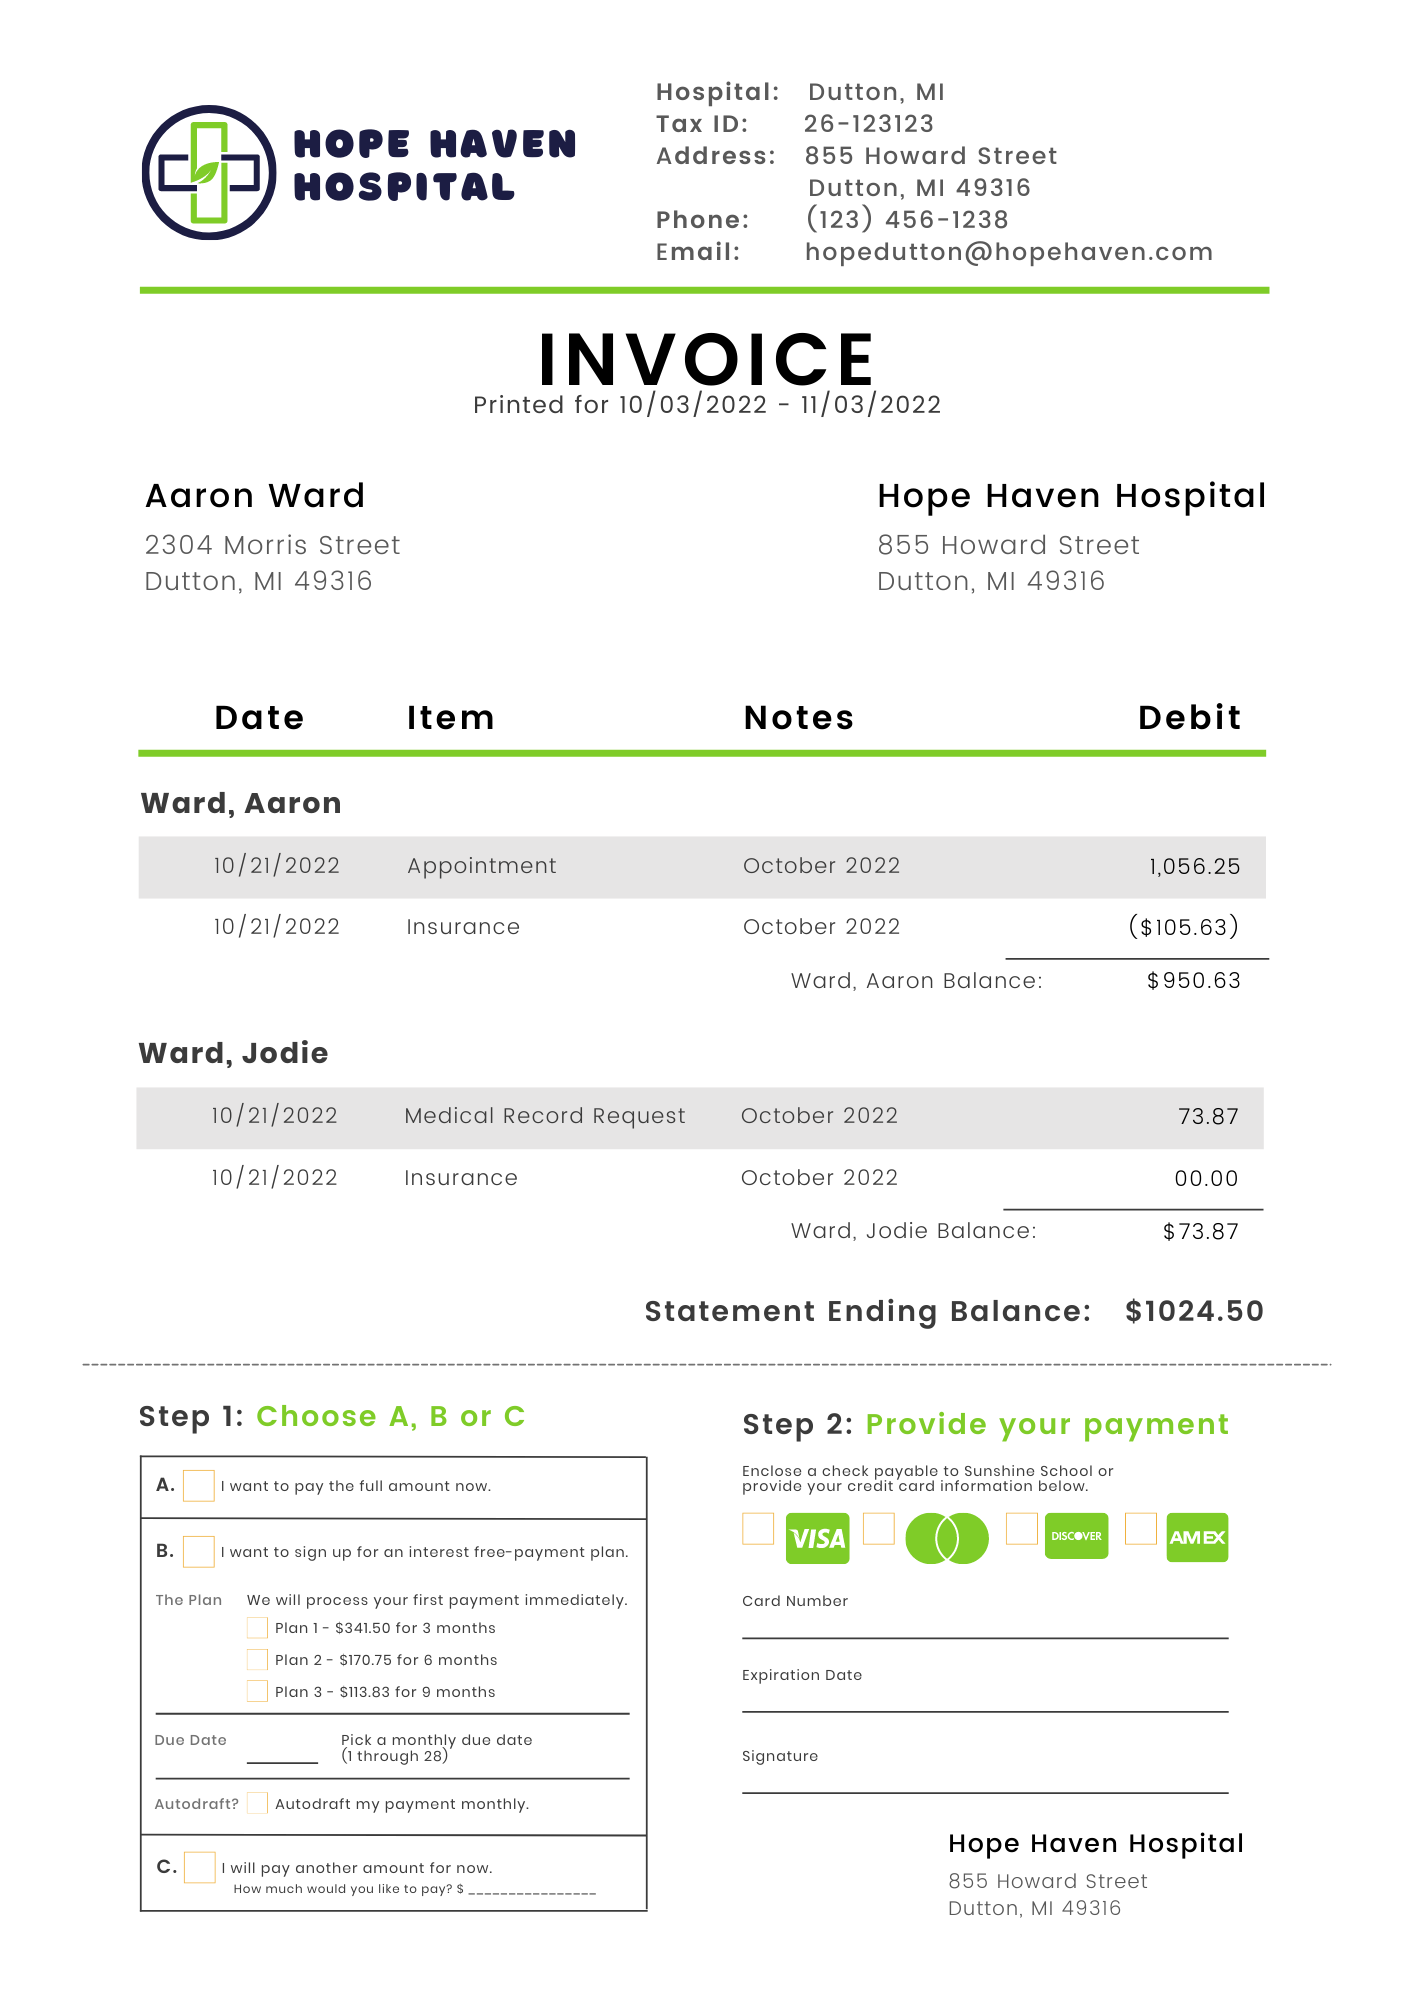

In [2]:
image_example = files('resources/images/Invoice.png')

df = spark.read.format("binaryFile") \
    .load(image_example)

df.show_image()


## Zero-Shot data Extraction from the Image

For run this example you need get free API key for gemini here: https://aistudio.google.com/apikey

Or use another LLM provider which provide multimodal model.

> LLMVisualExtractor supports OpenAI compatible API, so please set right `apiBase`, `apiKey`  and `model` parameter.
>
> More general way to set env variables: `OPENAI_API_KEY`, `OPENAI_BASE_URL`

In [5]:
from pydantic import BaseModel
import json

class Items(BaseModel):
    date: str
    item: str
    note: str
    debit: str

class InvoiceSchema(BaseModel):
    hospital: str
    tax_id: str
    address: str
    email: str
    phone: str
    items: list[Items]
    total: str
    

pipeline = PipelineModel(stages=[
    DataToImage(
        inputCol="content",
        outputCol="image"
    ),
    LLMVisualExtractor(
        inputCol="image",
        outputCol="invoice",
        model="gemini-1.5-flash",
        apiKey="",
        apiBase="https://generativelanguage.googleapis.com/v1beta/",
        schema=json.dumps(InvoiceSchema.model_json_schema())
    )
])

result = pipeline.transform(df).cache()

## Show the extracted json

In [6]:
result.show_json("invoice")

## Show results Data Frame

In [7]:
result.show()

+--------------------+--------------------+------+--------------------+--------------------+
|                path|    modificationTime|length|               image|             invoice|
+--------------------+--------------------+------+--------------------+--------------------+
|file:/home/mykola...|2024-11-18 21:06:...|289502|{file:/home/mykol...|{file:/home/mykol...|
+--------------------+--------------------+------+--------------------+--------------------+



In [7]:
result.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- path: string (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |    |-- imageType: string (nullable = false)
 |    |-- exception: string (nullable = false)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |-- invoice: struct (nullable = true)
 |    |-- path: string (nullable = false)
 |    |-- json_data: string (nullable = true)
 |    |-- type: string (nullable = false)
 |    |-- exception: string (nullable = false)
 |    |-- processing_time: double (nullable = false)
 |    |-- data: struct (nullable = true)
 |    |    |-- hospital: string (nullable = false)
 |    |    |-- tax_id: string (nullable = false)
 |    |    |-- address: string (nullable = false)
 |    |    |-- email: string (nullable = false)
 |    |    

## Let's show Invoice as Structured Data in Data Frame

In [9]:
result.select("invoice.data.*").show()

+-------------------+---------+--------------------+--------------------+--------------+--------------------+-------+
|           hospital|   tax_id|             address|               email|         phone|               items|  total|
+-------------------+---------+--------------------+--------------------+--------------+--------------------+-------+
|Hope Haven Hospital|26-123123|855 Howard Street...|hopedutton@hopeha...|(123) 456-1238|[{10/21/2022, App...|1024.50|
+-------------------+---------+--------------------+--------------------+--------------+--------------------+-------+

